In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting
import seaborn as sns #good visualizing
import os
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("Resources"))
white_data = pd.read_csv('Resources/wineQualityWhites.csv')
white_data.columns = white_data.columns.str.replace(' ','_')
white_data.info()

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree


['.ipynb_checkpoints', 'winequality-red.csv', 'wineQualityReds.csv', 'wineQualityWhites.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
Unnamed:_0              4898 non-null int64
fixed.acidity           4898 non-null float64
volatile_acidity        4898 non-null float64
citric.acid             4898 non-null float64
residual.sugar          4898 non-null float64
chlorides               4898 non-null float64
free.sulfur.dioxide     4898 non-null float64
total.sulfur.dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(2)
memory usage: 497.5 KB


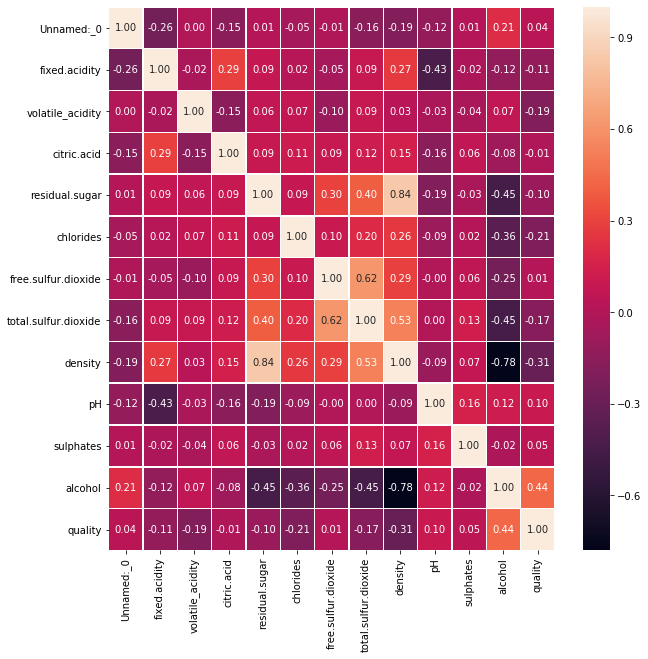

In [2]:
white_data.corr() 
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(white_data.corr(), annot = True, linewidths=.5, fmt = ".2f", ax=ax)
plt.show()

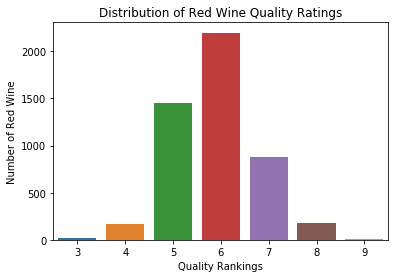

In [3]:
sns.barplot(white_data['quality'].unique(),white_data['quality'].value_counts())
plt.xlabel("Quality Rankings")
plt.ylabel("Number of Red Wine")
plt.title("Distribution of Red Wine Quality Ratings")
plt.show()

In [4]:
print(white_data['quality'].value_counts())

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import graphviz  
from sklearn.externals.six import StringIO
from IPython.display import Image 

#Normalization ==> x_norm = (x - mean)/std 
#it gives for each value the same value intervals means between 0-1
def normalization(X):
    mean = np.mean(X)
    std = np.std(X)
    X_t = (X - mean)/std
    return X_t

#Train and Test splitting of data     
def train_test(X_t, y):
    x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size = 0.3, random_state = 42)
    print("Train:",len(x_train), " - Test:", len(x_test))
    return x_train, x_test, y_train, y_test

def grid_search(name_clf, clf, x_train, x_test, y_train, y_test):
    if name_clf == 'Logistic_Regression':
        # Logistic Regression 
        log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
        grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
        grid_log_reg.fit(x_train, y_train)
        # We automatically get the logistic regression with the best parameters.
        log_reg = grid_log_reg.best_estimator_
        print("Best Parameters for Logistic Regression: ", grid_log_reg.best_estimator_)
        print("Best Score for Logistic Regression: ", grid_log_reg.best_score_)
        print("------------------------------------------")
        return log_reg
    
    elif name_clf == 'SVM':
        # Support Vector Classifier
        svc_params = {'C':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                      'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
        grid_svc = GridSearchCV(SVC(), svc_params)
        grid_svc.fit(x_train, y_train)
        # SVC best estimator
        svc = grid_svc.best_estimator_
        print("Best Parameters for SVM: ", grid_svc.best_estimator_)
        print("Best Score for SVM: ", grid_svc.best_score_)
        print("------------------------------------------")
        return svc
    
    elif name_clf == 'Decision_Tree':
        # DecisionTree Classifier
        tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,30,1)), 
                  "min_samples_leaf": list(range(5,20,1))}
        grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
        grid_tree.fit(x_train, y_train)
        # tree best estimator
        tree_clf = grid_tree.best_estimator_
        print("Best Parameters for Decision Tree: ", grid_tree.best_estimator_)
        print("Best Score for Decision Tree: ", grid_tree.best_score_)
        print("------------------------------------------")
        
        #FEATURE IMPORTANCE FOR DECISION TREE
        importnce = tree_clf.feature_importances_
        plt.figure(figsize=(10,10))
        plt.title("Feature Importances of Decision Tree")
        plt.barh(X_t.columns, importnce, align="center")
        
        return tree_clf
    
    elif name_clf == 'Random_Forest':
        forest_params = {"bootstrap":[True, False], "max_depth": list(range(2,10,1)), 
                  "min_samples_leaf": list(range(5,20,1))}
        grid_forest = GridSearchCV(RandomForestClassifier(), forest_params)
        grid_forest.fit(x_train, y_train)
        # forest best estimator
        forest_clf = grid_forest.best_estimator_
        print("Best Parameters for Random Forest: ", grid_forest.best_estimator_)
        print("Best Score for Random Forest: ", grid_forest.best_score_)
        print("------------------------------------------")
        
        #FEATURE IMPORTANCE FOR DECISION TREE
        importnce = forest_clf.feature_importances_
        plt.figure(figsize=(10,10))
        plt.title("Feature Importances of Random Forest")
        plt.barh(X_t.columns, importnce, align="center")
        
        return forest_clf
    
def plot_learning_curve(estimator,title, X, y, ylim=None, cv=None, n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Create applying classification funciton
def apply_classification(name_clf, clf, x_train, x_test, y_train, y_test):
    #Find the best parameters and get the classification with the best parameters as return valu of grid search
    grid_clf = grid_search(name_clf, clf, x_train, x_test, y_train, y_test)
    
    #Plotting the learning curve
    # score curves, each time with 30% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    plot_learning_curve(grid_clf, name_clf, x_train, y_train, 
                    ylim=(0.1, 1.01), cv=cv, n_jobs=4)
    
    #Apply cross validation to estimate the skills of models with 10 split with using best parameters
    scores = cross_val_score(grid_clf, x_train, y_train, cv=10)
    print("Mean Accuracy of Cross Validation: %", round(scores.mean()*100,2))
    print("Std of Accuracy of Cross Validation: %", round(scores.std()*100))
    print("------------------------------------------")
    
    #Predict the test data as selected classifier
    clf_prediction = grid_clf.predict(x_test)
    clf1_accuracy = sum(y_test == clf_prediction)/len(y_test)
    print("Accuracy of",name_clf,":",clf1_accuracy*100)
    
    #print confusion matrix and accuracy score before best parameters
    clf1_conf_matrix = confusion_matrix(y_test, clf_prediction)
    print("Confusion matrix of",name_clf,":\n", clf1_conf_matrix)
    print("==========================================")
    return grid_clf




C:\Users\Stephanie Villegas\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [6]:
#Now seperate the dataset as response variable and feature variabes
X = white_data.drop(['quality'], axis = 1)
#y = pd.DataFrame(data['value'])
y = white_data['quality']


In [7]:
#Normalization
X_t = normalization(X)
print("X_t:", X_t.shape)

#Train and Test splitting of data 
x_train, x_test, y_train, y_test = train_test(X_t, y)

X_t: (4898, 12)
Train: 3428  - Test: 1470


In [ ]:
from sklearn.svm import SVC

svm = SVC()
apply_classification('SVM', svm, x_train, x_test, y_train, y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree

dt = DecisionTreeClassifier()
dt_clf = apply_classification('Decision_Tree', dt, x_train, x_test, y_train, y_test)
